In [1]:
import pandas as pd
import os.path
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer,PolynomialFeatures
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

pd.set_option('display.max_columns', None)

# The below suppresses all warnings in the notebook
# Only leave this uncommented for display purposes
import warnings
warnings.filterwarnings("ignore")

Set names and paths for loading

In [2]:
# Where processed files are saved to
processed_data_folder = '/Users/bryan/Movies/Data For TDI Project/Processed_Data_County_Level'

file_name = 'county_attr_df.csv'

Load the previously created county_attr_df into memory

In [3]:
county_attr_df = pd.read_csv(os.path.join(processed_data_folder,file_name))

# Drop unnecessary column (artificat from being read in)
county_attr_df.drop(columns=['Unnamed: 0'], inplace=True)

county_attr_df.head()

,FIPS,Mean Income,Unemployment Rate,Rural-Urban Continuum Code,CountyName,Avg Num Of Sales,crime_rate_per_100000,Avg Listing Price,Avg Listing Per Sqr Ft,StateName
0,1000,48193.0,4.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,58343.0,3.9,2.0,Autauga,NaN,251.601926,200641.125000,101.445131,Alabama
2,1003,56607.0,4.0,3.0,Baldwin,458.500000,228.086325,306246.250000,147.828333,Alabama
3,1005,32490.0,5.9,6.0,Barbour,NaN,177.278771,163670.833333,88.227731,Alabama
4,1007,45795.0,4.4,1.0,Bibb,4.666667,217.661691,144979.083333,87.040312,Alabama


I will now investigate the missingness of the data

In [4]:
# Shows missing value information for provided dataframe
def nan_investigation(df):
    num_entries = df.shape[0]
    df_titles = list(df.columns.values)
    nan_count_df = pd.DataFrame(columns=df_titles,index=['Tot_Null','Tot_Not_Null','Perc_Null'])
    for column in df:
        nan_sum = df[column].isnull().sum()
        nan_count_df.set_value('Tot_Null', column, nan_sum)
        nan_count_df.set_value('Tot_Not_Null', column, num_entries-nan_sum)
        nan_count_df.set_value('Perc_Null', column, nan_sum/num_entries)

    display(nan_count_df)

In [5]:
nan_investigation(county_attr_df)

,FIPS,Mean Income,Unemployment Rate,Rural-Urban Continuum Code,CountyName,Avg Num Of Sales,crime_rate_per_100000,Avg Listing Price,Avg Listing Per Sqr Ft,StateName
Tot_Null,0,89,10,62,137,602,145,1044,1112,137
Tot_Not_Null,3281,3192,3271,3219,3144,2679,3136,2237,2169,3144
Perc_Null,0,0.0271259,0.00304785,0.0188967,0.0417556,0.183481,0.0441938,0.318196,0.338921,0.0417556


From the above we can see that we have nearly all data for the following:<br>
Mean Income<br>
Unemployment Rate<br>
Rural-Urban Continuum Code<br>
crime_rate_per_100000<br>
StateName<br>
CountyName<br>

But that we are missing significatn data for:<br>
Avg Num of Sales<br>
Avg Listing Price<br>
Avg Listing Per Sqr Ft<br>

These three which are missing a significant number of columns are also some of the most important for deciding where to purchase a house<br>
What I will do is investigate this further and then attempt data imputation.<br>
Let me first make plots of the nullity to ensure I cannot visually see any pattern in it

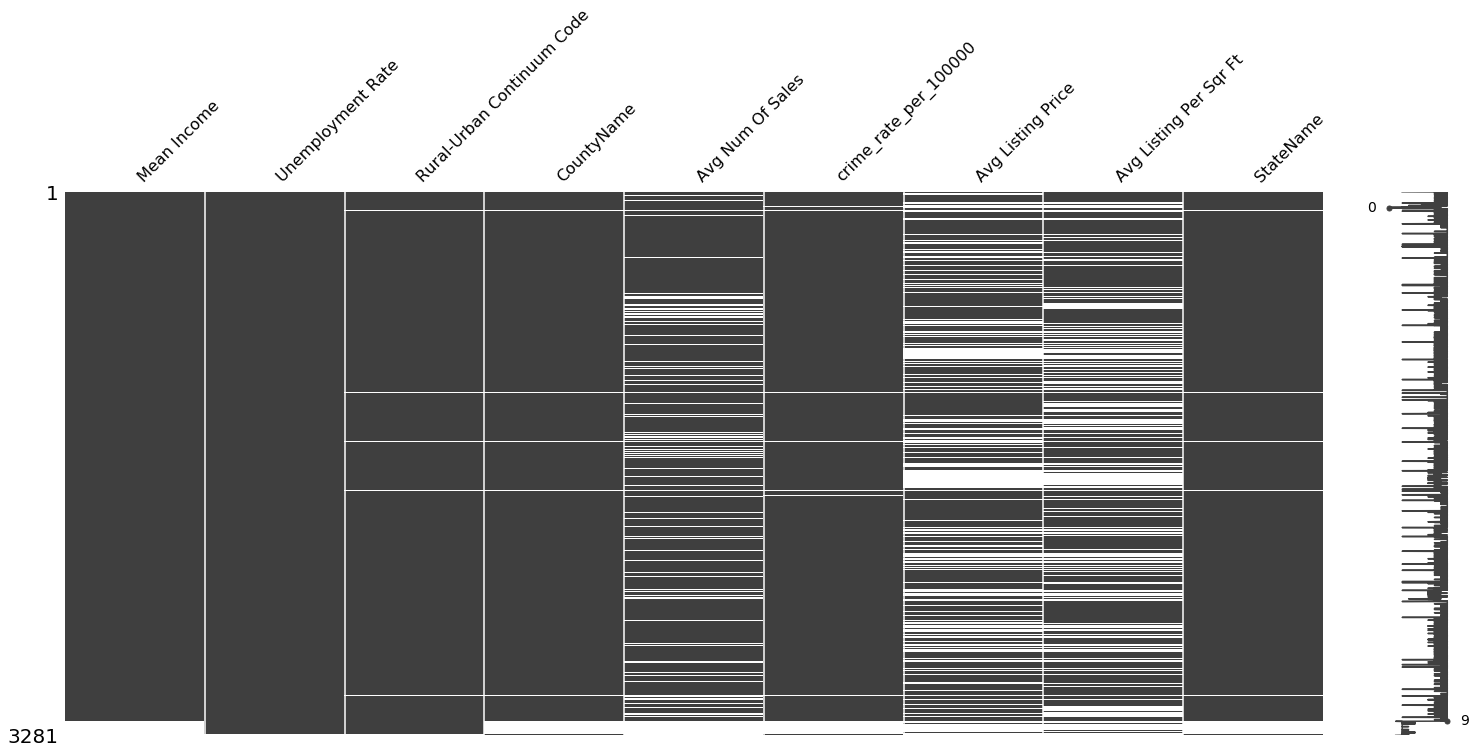

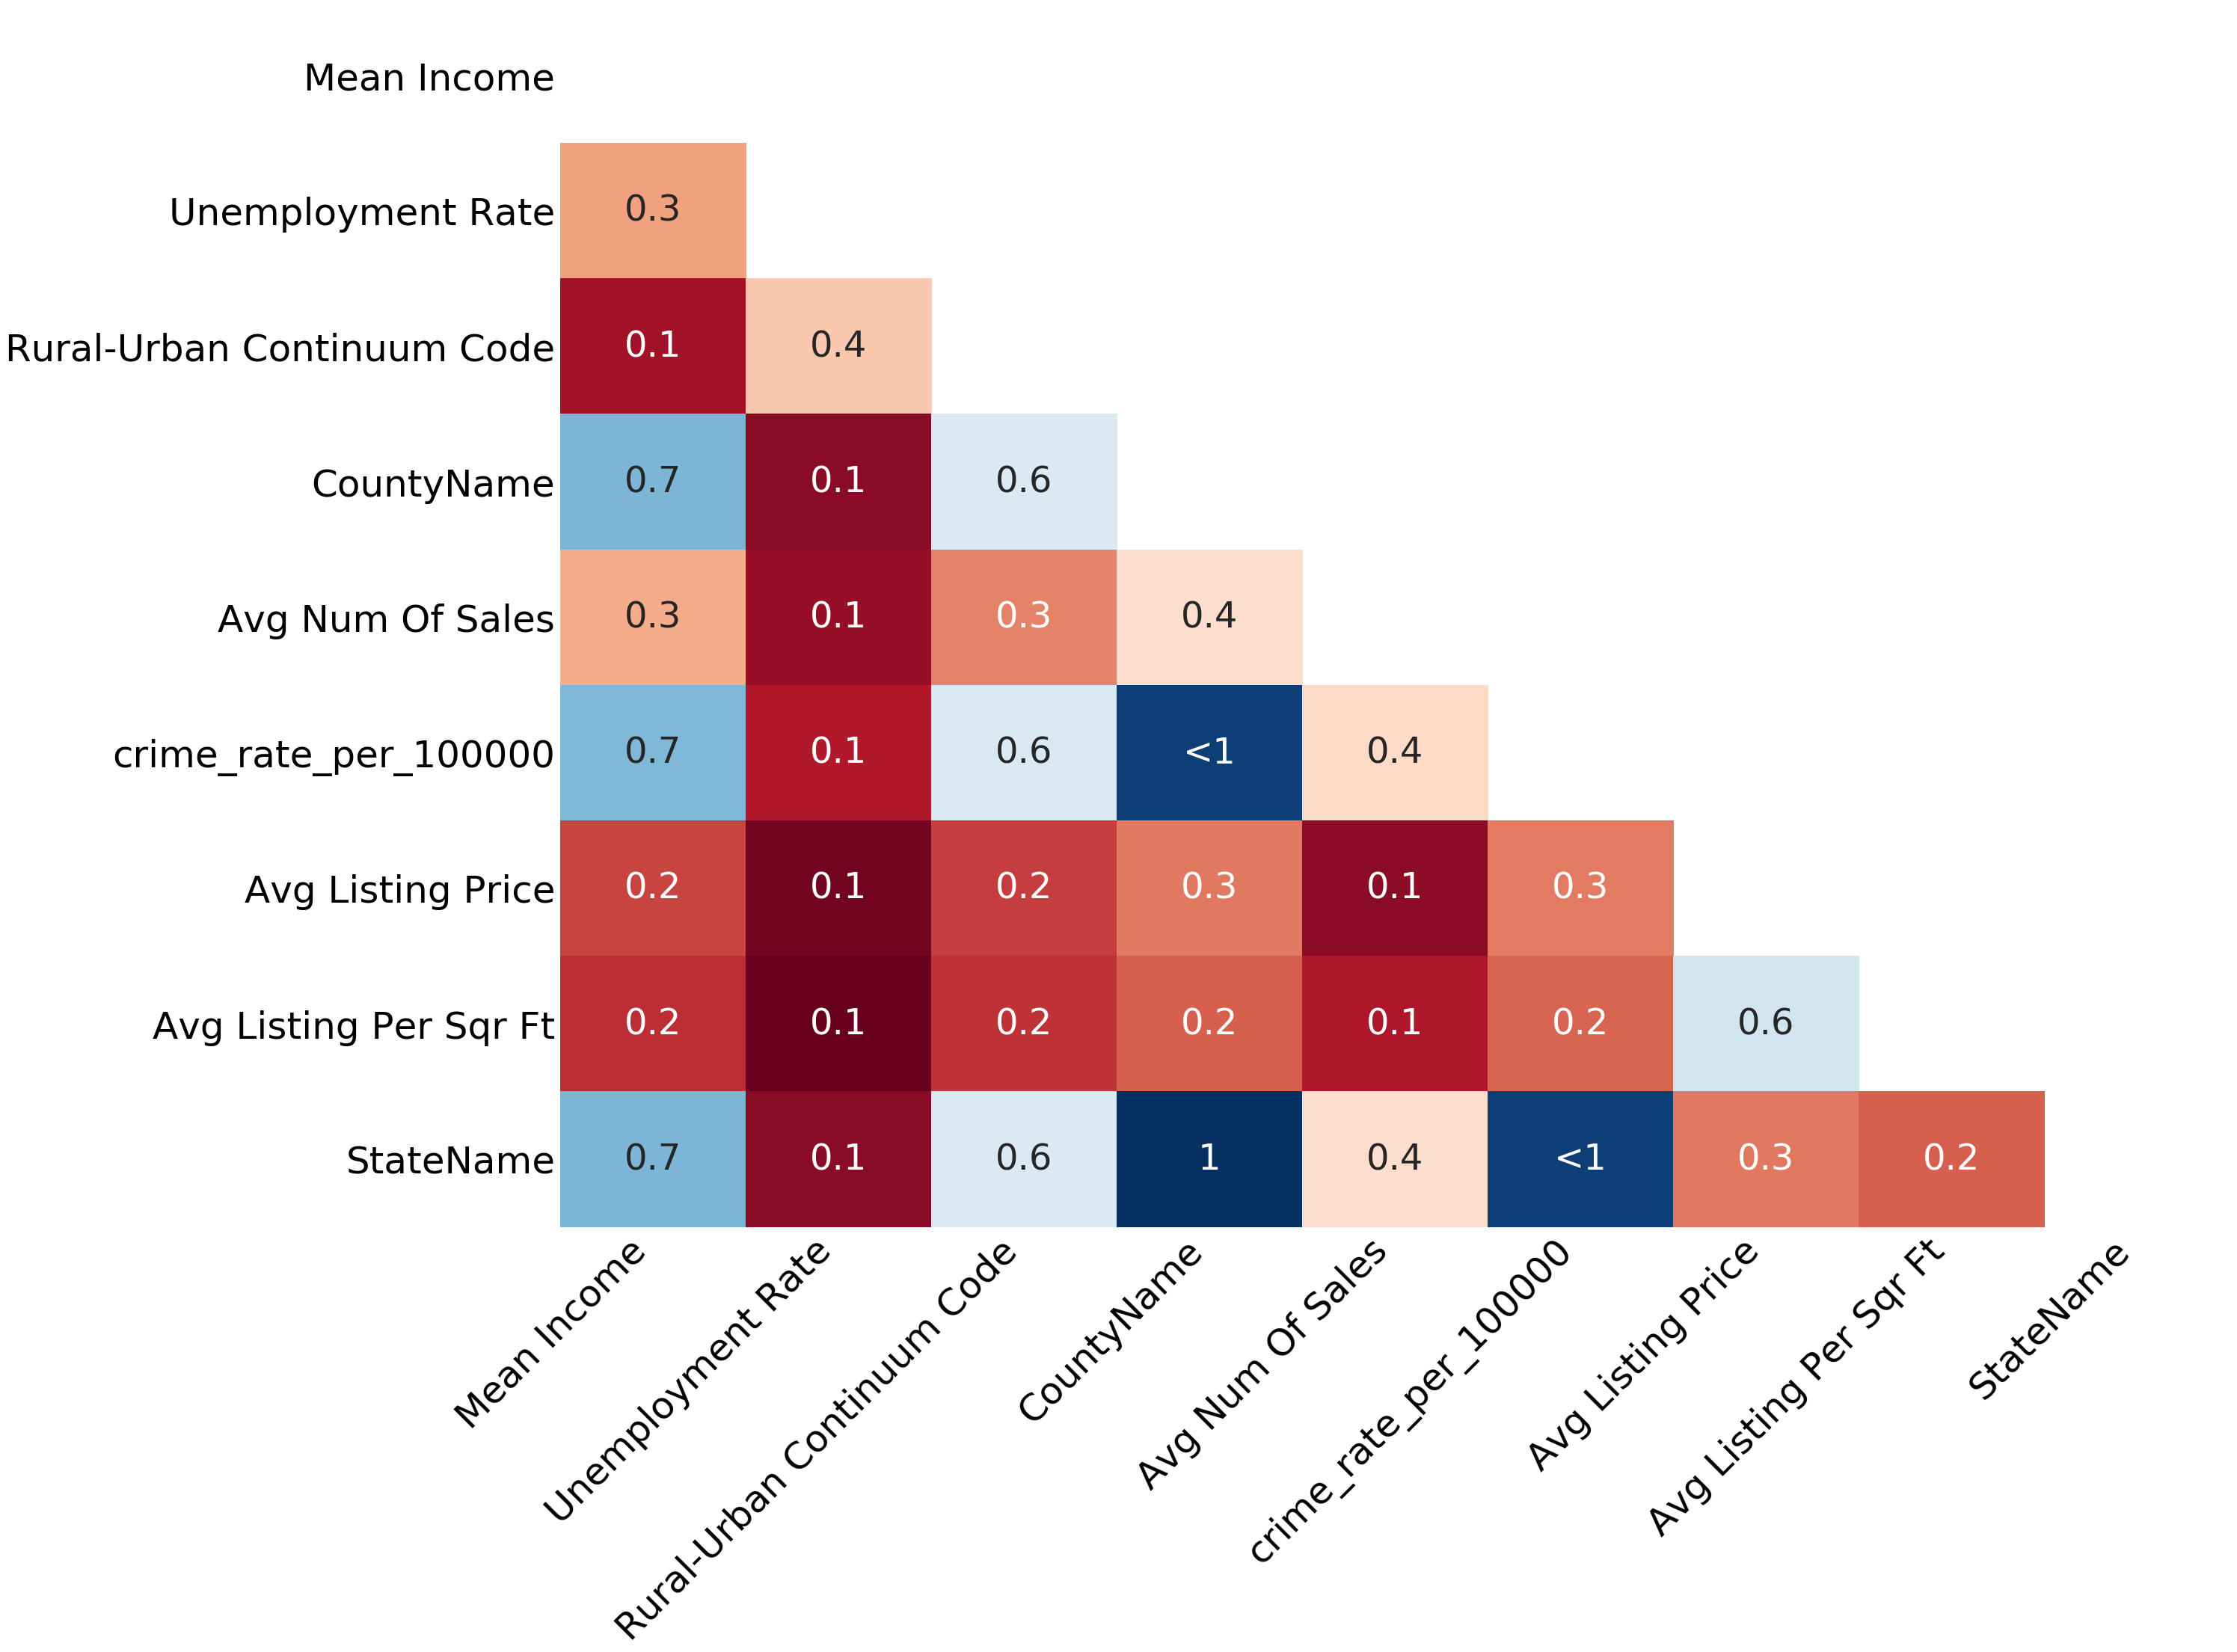

In [6]:
missingdata_df = county_attr_df.columns[county_attr_df.isnull().any()].tolist()
msno.matrix(county_attr_df[missingdata_df])

msno.heatmap(county_attr_df[missingdata_df],figsize=(40,30),fontsize=50)

From the above I do see a relationship between Rural-Urban Continuum Code, crime_rate_per_100000, and StateName, but I believe this likely comes from the way I built this dataframe<br>
I performed outer joins between the dataframes, thus creating empty entries anywhere were an entry existed for one feature but not for others<br>
Thus, to me the above appears to look like what is expected from a performance like this.<br>
I do not think there is any reason to doubt that the data is missing randomly from each database, and I am therefore safe to continue investigating this dataset

I will now investigate the correlations between all features

In [7]:
def heatMap(df,des_figsize=(10,10)):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=des_figsize)
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()

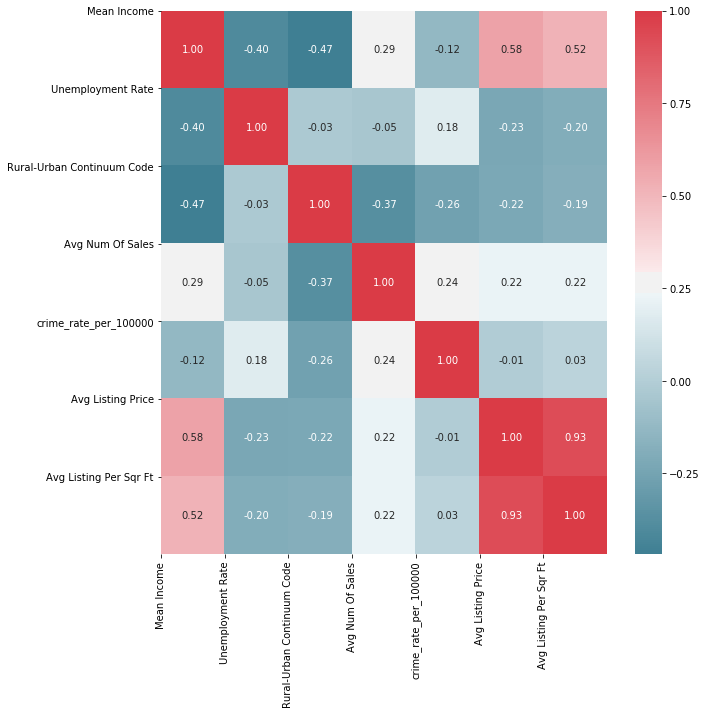

In [8]:
for_heatmap = county_attr_df.drop(columns=['FIPS'])
heatMap(for_heatmap)

From the above we can see a strong correlation between Avg Listing Per Sqr Ft and Avg Listing Price, which of course makes perfect sense from domain knowledge<br>
Other than that there is a somewhat strong correlation (mid 50's) between Mean Income and Avg Listing Price or Avg Listing Price Per Sqr Ft<br>
Continue later........

We now create Seaborn Pairwise Plots to assess covariance between these features

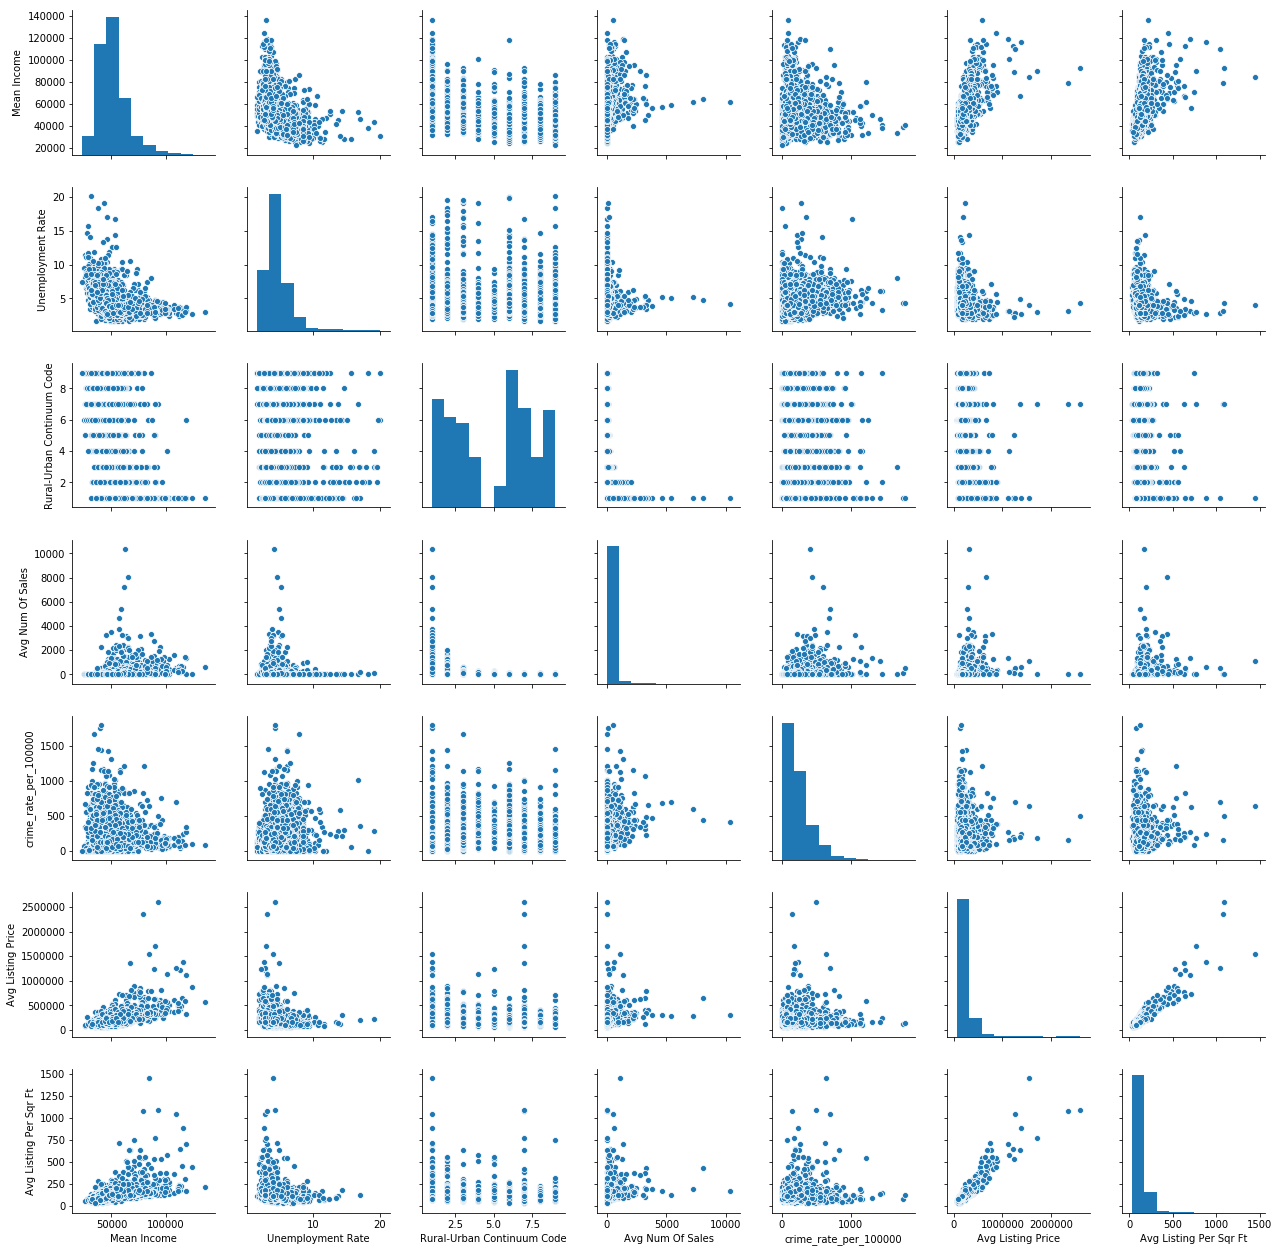

In [9]:
sns.pairplot(for_heatmap)

From here I do see some pretty significant covariances<br>

Below I create some individual pairwise plots for some of the interesting relationships shown above.

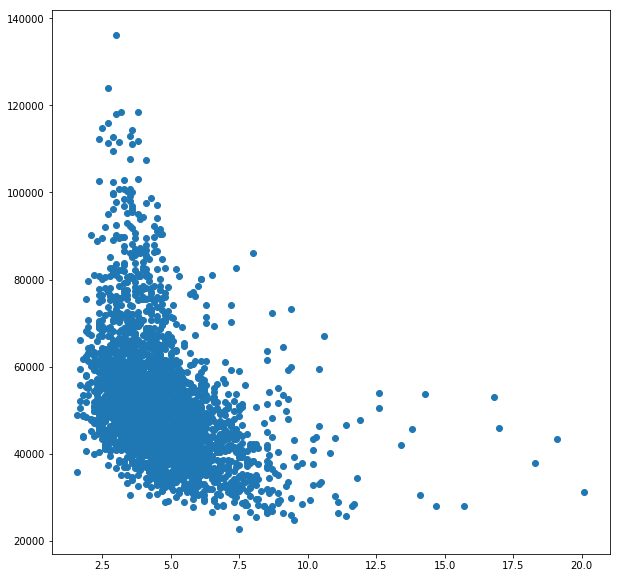

In [12]:
# Plot Unemployment Rate against Mean Income
plt.figure(figsize=(10,10))
plt.scatter(county_attr_df['Unemployment Rate'],county_attr_df['Mean Income'])
plt.show()

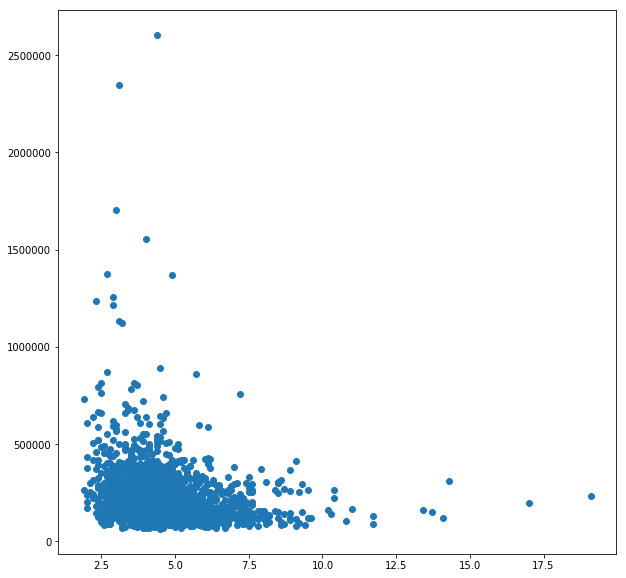

In [13]:
# Plot Unemployment Rate against Avg Listing Price
plt.figure(figsize=(10,10))
plt.scatter(county_attr_df['Unemployment Rate'],county_attr_df['Avg Listing Price'])
plt.show()

In [ ]:
# Plot Rural-Urban Code against Avg Number of Sales

I will now utilize MICE (Multiple Imputations by Chained Equations)<br>
I am still becoming familiar with this approach, and will improve this code as I learn more

In [10]:
class MiceImputer():

    def __init__(self, missing_values="NaN", strategy="mean", axis=0, verbose=0, copy=True):
        self.missing_values = missing_values
        self.strategy = strategy
        self.axis = axis
        self.verbose = verbose
        self.copy = copy
        self.imp = Imputer(missing_values=self.missing_values, strategy=self.strategy, axis= self.axis, verbose=self.verbose, copy=self.copy)

    def _seed_values(self, X):
        self.imp.fit(X)
        return self.imp.transform(X)

    def _get_mask(self,X, value_to_mask="NaN"):
        if value_to_mask == "NaN" or np.isnan(value_to_mask):
            return np.isnan(X)
        else:
            return X == value_to_mask

    def _process(self, X, column, model_class):
        # Remove values that are in mask
        mask = np.array(self.mask[:, column].T)[0]

        mask_indices = np.where(mask==True)[0]
        X_data = np.delete(X, mask_indices, 0)

        # Instantiate the model
        model = model_class()
        
        # Slice out the column to predict and delete the column.
        y_data = X_data[:, column]
        X_data = np.delete(X_data, column, 1)

        # Split training and test data
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42)

        # Fit the model
        model.fit(X_train, y_train)

        # Score the model
        scores = model.score(X_test, y_test)

        # Predict missing vars
        X_predict = np.delete(X, column, 1)
        y = model.predict(X_predict)

        # Replace values in X with their predictions
        predict_indices = np.where(mask==True)[0]

        X_col = X[:,column] # Make copy of column where imputed values will be placed
        np.put(X_col, predict_indices, np.take(y, predict_indices))

        # Now put imputed column back into X
        X[:,column] = X_col
        
        # Return model and scores
        return (model, scores)

    def transform(self, X, model_class=LinearRegression, iterations=10):
        X = np.matrix(X)

        self.mask = self._get_mask(X)
        
        X = self._seed_values(X)

        specs = np.zeros((iterations, len(X.T)))

        for i in range(iterations):

            for c in range(len(X.T) - 1):
                specs[i][c] = self._process(X, c, model_class)[1]

        # Return X matrix with imputed values
        return (X, specs)

In [11]:
county_attr_df.describe()

,FIPS,Mean Income,Unemployment Rate,Rural-Urban Continuum Code,Avg Num Of Sales,crime_rate_per_100000,Avg Listing Price,Avg Listing Per Sqr Ft
count,3281.000000,3192.000000,3271.000000,3219.000000,2679.000000,3136.000000,2.237000e+03,2169.000000
mean,31377.817738,51237.164160,4.817273,4.938490,151.608969,235.085665,2.205710e+05,128.886844
std,16358.069955,13499.515713,2.175020,2.724553,463.493208,200.502872,1.475761e+05,85.549519
min,1000.000000,22679.000000,1.600000,1.000000,0.000000,0.000000,6.241667e+04,28.402441
25%,19023.000000,42434.250000,3.500000,2.000000,5.000000,94.641916,1.415417e+05,86.660299
50%,30023.000000,49067.000000,4.400000,6.000000,24.818182,185.948066,1.842292e+05,110.329073
75%,46105.000000,56968.500000,5.500000,7.000000,100.045455,321.367803,2.600458e+05,145.894848
max,78030.000000,136191.000000,20.100000,9.000000,10358.666667,1791.995377,2.604792e+06,1452.578905


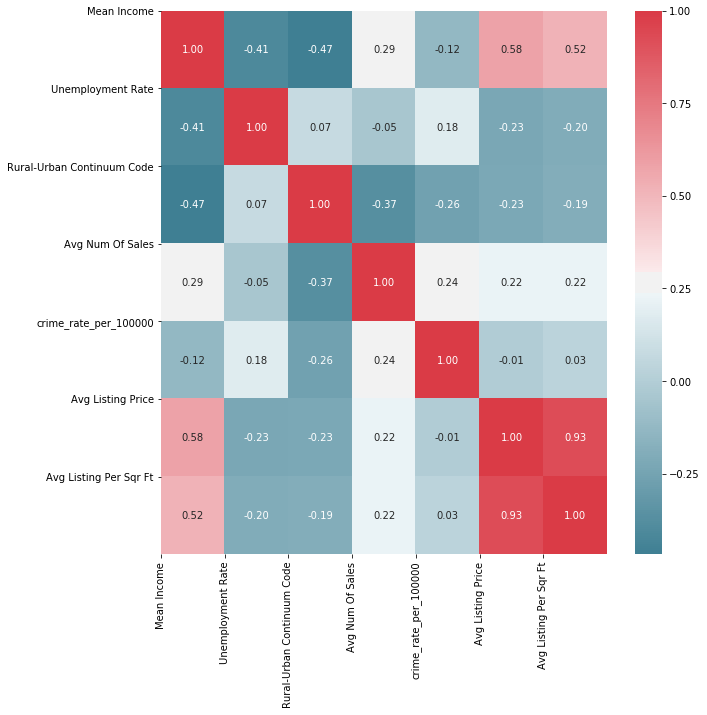

In [12]:
max_elems_missing = 3

# Make copy of dataframe
for_county_recommendations = county_attr_df.copy(deep=True)

# We first drop any rows missing 3 or more elements, as those will likely not be able to be imputed very
# well anyway
for_county_recommendations.dropna(thresh=(for_county_recommendations.shape[1]-max_elems_missing),inplace=True)
# Reset index after removing entries so there is no confusion after splitting pieces out and putting them back in
for_county_recommendations.reset_index(inplace=True)

for_heatmap = for_county_recommendations.drop(columns=['index','FIPS'])
heatMap(for_heatmap)

In [13]:
# The column for State Names can clearly not be imputed
# We therefore temporarily remove that, and put it back in after imputation
state_df = for_county_recommendations['StateName'].copy(deep=True)
fips_df = for_county_recommendations['FIPS'].copy(deep=True)
county_df = for_county_recommendations['CountyName'].copy(deep=True)
# For imputation cannot include string-type features
to_impute_df = for_county_recommendations.drop(columns=['StateName','FIPS','CountyName']).copy(deep=True)
column_names = to_impute_df.columns

# Now turn this into a numpy array
to_impute_array = to_impute_df.values

imputer = MiceImputer(missing_values=np.nan,axis=0)

# X, specs = imputer.transform(to_impute_array, LinearRegression, 10)
X, specs = imputer.transform(to_impute_array, RandomForestRegressor, 10)
# X, specs = imputer.transform(to_impute_array, KNeighborsRegressor, 10)

# We now put the removed features back in
for_county_recommendations = pd.DataFrame(X,columns=column_names) # Make fresh copy with new dataframe in it

for_county_recommendations['FIPS'] = fips_df
for_county_recommendations['StateName'] = state_df
for_county_recommendations['CountyName'] = county_df

nan_investigation(for_county_recommendations)

,index,Mean Income,Unemployment Rate,Rural-Urban Continuum Code,Avg Num Of Sales,crime_rate_per_100000,Avg Listing Price,Avg Listing Per Sqr Ft,FIPS,StateName,CountyName
Tot_Null,0,0,0,0,0,0,0,0,0,0,0
Tot_Not_Null,3137,3137,3137,3137,3137,3137,3137,3137,3137,3137,3137
Perc_Null,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# We now drop any remaining rows, as we need a FIPS and StateName for every marker
for_county_recommendations.dropna(how='any',inplace=True)

nan_investigation(for_county_recommendations)

,index,Mean Income,Unemployment Rate,Rural-Urban Continuum Code,Avg Num Of Sales,crime_rate_per_100000,Avg Listing Price,Avg Listing Per Sqr Ft,FIPS,StateName,CountyName
Tot_Null,0,0,0,0,0,0,0,0,0,0,0
Tot_Not_Null,3137,3137,3137,3137,3137,3137,3137,3137,3137,3137,3137
Perc_Null,0,0,0,0,0,0,0,0,0,0,0


In [15]:
for_county_recommendations.describe()

,index,Mean Income,Unemployment Rate,Rural-Urban Continuum Code,Avg Num Of Sales,crime_rate_per_100000,Avg Listing Price,Avg Listing Per Sqr Ft,FIPS
count,3137.000000,3137.000000,3137.000000,3137.000000,3137.000000,3137.000000,3.137000e+03,3137.000000,3137.000000
mean,1601.332483,51103.803315,4.607364,5.005100,144.706842,235.441660,2.086585e+05,128.983141,30410.538094
std,920.509976,13498.378243,1.638305,2.707458,443.997538,200.386690,1.326375e+05,71.023453,15144.336150
min,1.000000,22679.000000,1.600000,1.000000,0.000000,0.000000,6.241667e+04,28.402441,1001.000000
25%,805.000000,42277.000000,3.500000,2.000000,6.000000,95.020905,1.393431e+05,96.862410,18183.000000
50%,1600.000000,48893.000000,4.400000,6.000000,25.508333,186.514968,1.778125e+05,128.983141,29179.000000
75%,2399.000000,56702.000000,5.400000,7.000000,91.545455,321.805211,2.435771e+05,128.983141,45081.000000
max,3194.000000,136191.000000,19.100000,9.000000,10358.666667,1791.995377,2.604792e+06,1452.578905,56045.000000


This is the dataframe which will be used for making recommendations about which county is the best match for a particular user<br>
We now save it to the disk

In [16]:
for_county_recommendations.to_csv(os.path.join(processed_data_folder,'for_county_recommendations.csv'))

After this imputation I now look at the higher order interaction terms as well to investigate correlations

In [17]:
def PolynomialFeatures_labeled(input_df,power):
    '''Basically this is a cover for the sklearn preprocessing function. 
    The problem with that function is if you give it a labeled dataframe, it ouputs an unlabeled dataframe with potentially
    a whole bunch of unlabeled columns. 

    Inputs:
    input_df = Your labeled pandas dataframe (list of x's not raised to any power) 
    power = what order polynomial you want variables up to. (use the same power as you want entered into pp.PolynomialFeatures(power) directly)

    Ouput:
    Output: This function relies on the powers_ matrix which is one of the preprocessing function's outputs to create logical labels and 
    outputs a labeled pandas dataframe   
    '''
    poly = PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s^%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

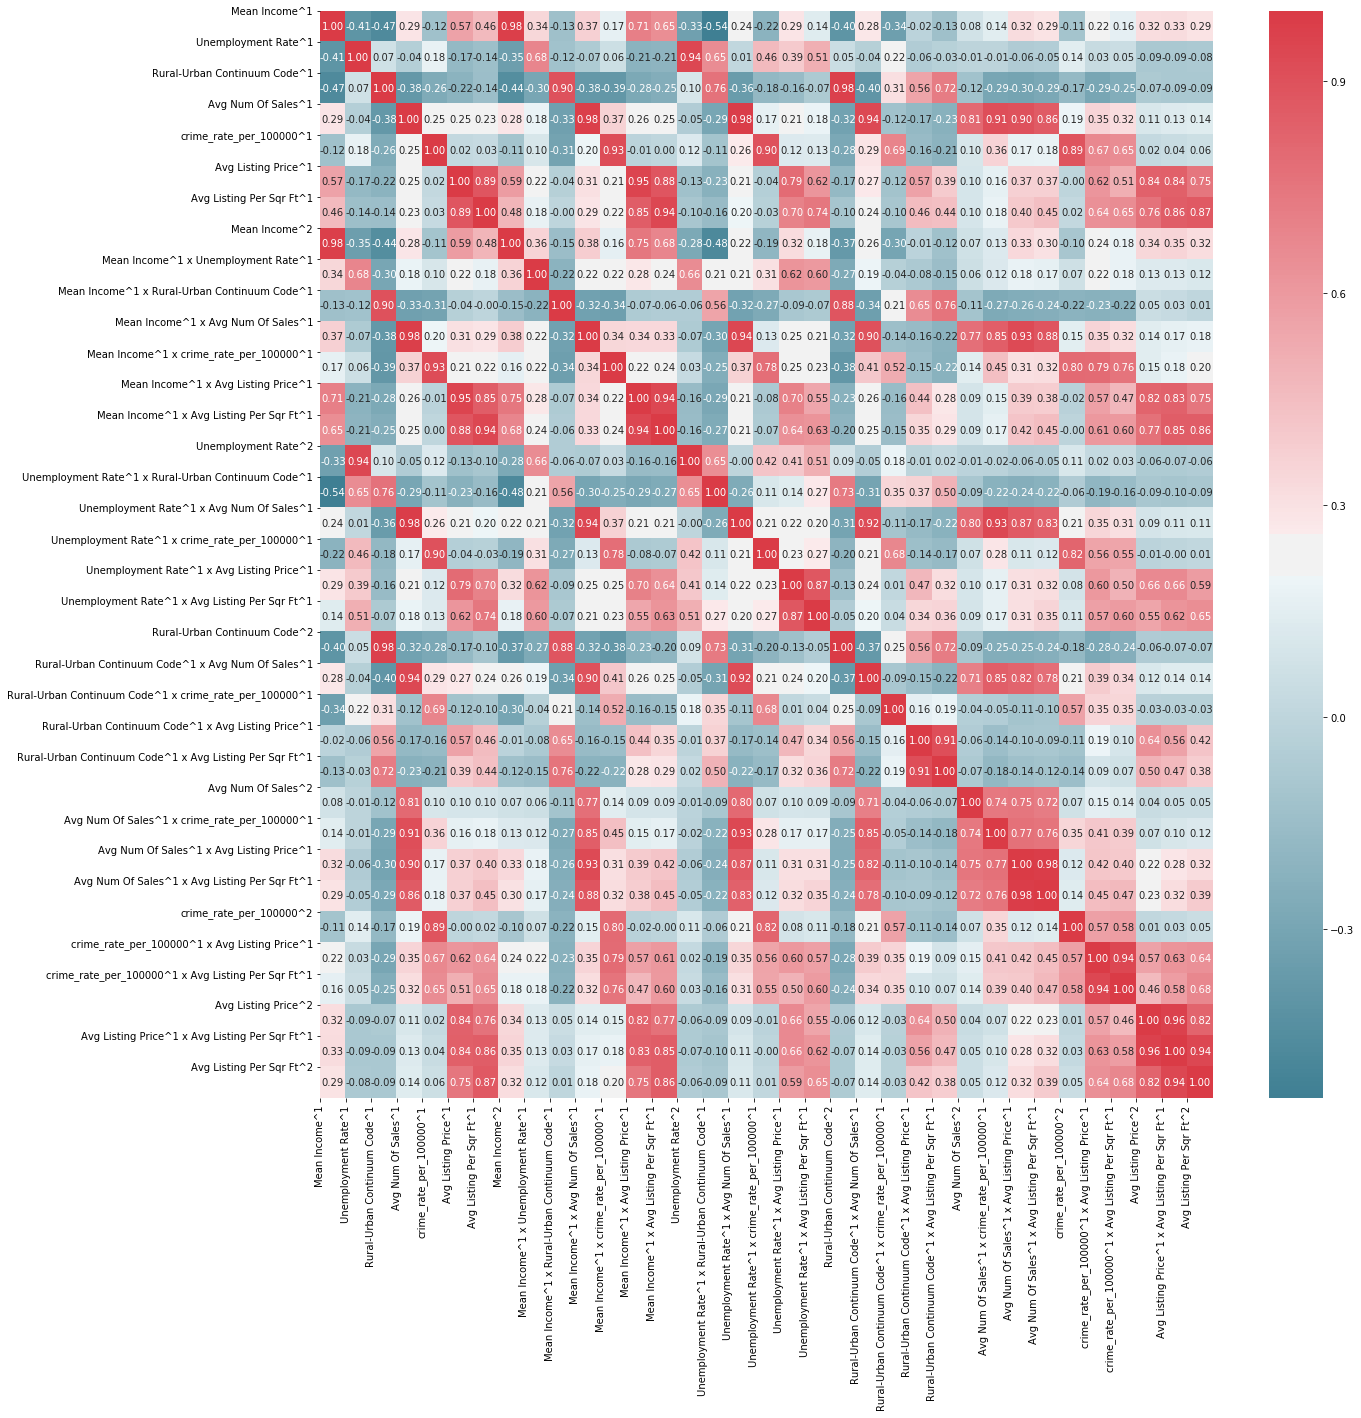

In [18]:
to_examine_df = for_county_recommendations.drop(columns=['index','FIPS','StateName','CountyName'])

# poly_features = PolynomialFeatures(degree=2, include_bias=False)
# feature_mat = poly_features.fit_transform(to_examine_df)
# # Get names for all columns
# col_names = poly_features.get_feature_names(to_examine_df.columns)

# expanded_feature_df = pd.DataFrame(feature_mat,columns=col_names)

expanded_feature_df = PolynomialFeatures_labeled(to_examine_df,2)
expanded_feature_df.drop(columns='Constant Term',inplace=True) # Remove the constant term for below heatmaps

heatMap(expanded_feature_df,(20,20))

There is too much information here to easily uncover, so I will create a heatmap showing all interactions with the unaffected 1st order terms

In [19]:
def heatMap_nonSquare(df,num_to_include,des_figsize=(10,10)):
    #Create Correlation df
    full_corr=df.corr()
    corr = df.corr()[df.columns[:num_to_include]]
    #Plot figsize
    fig, ax = plt.subplots(figsize=des_figsize)
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(full_corr.columns)), full_corr.columns)
    #show plot
    plt.show()

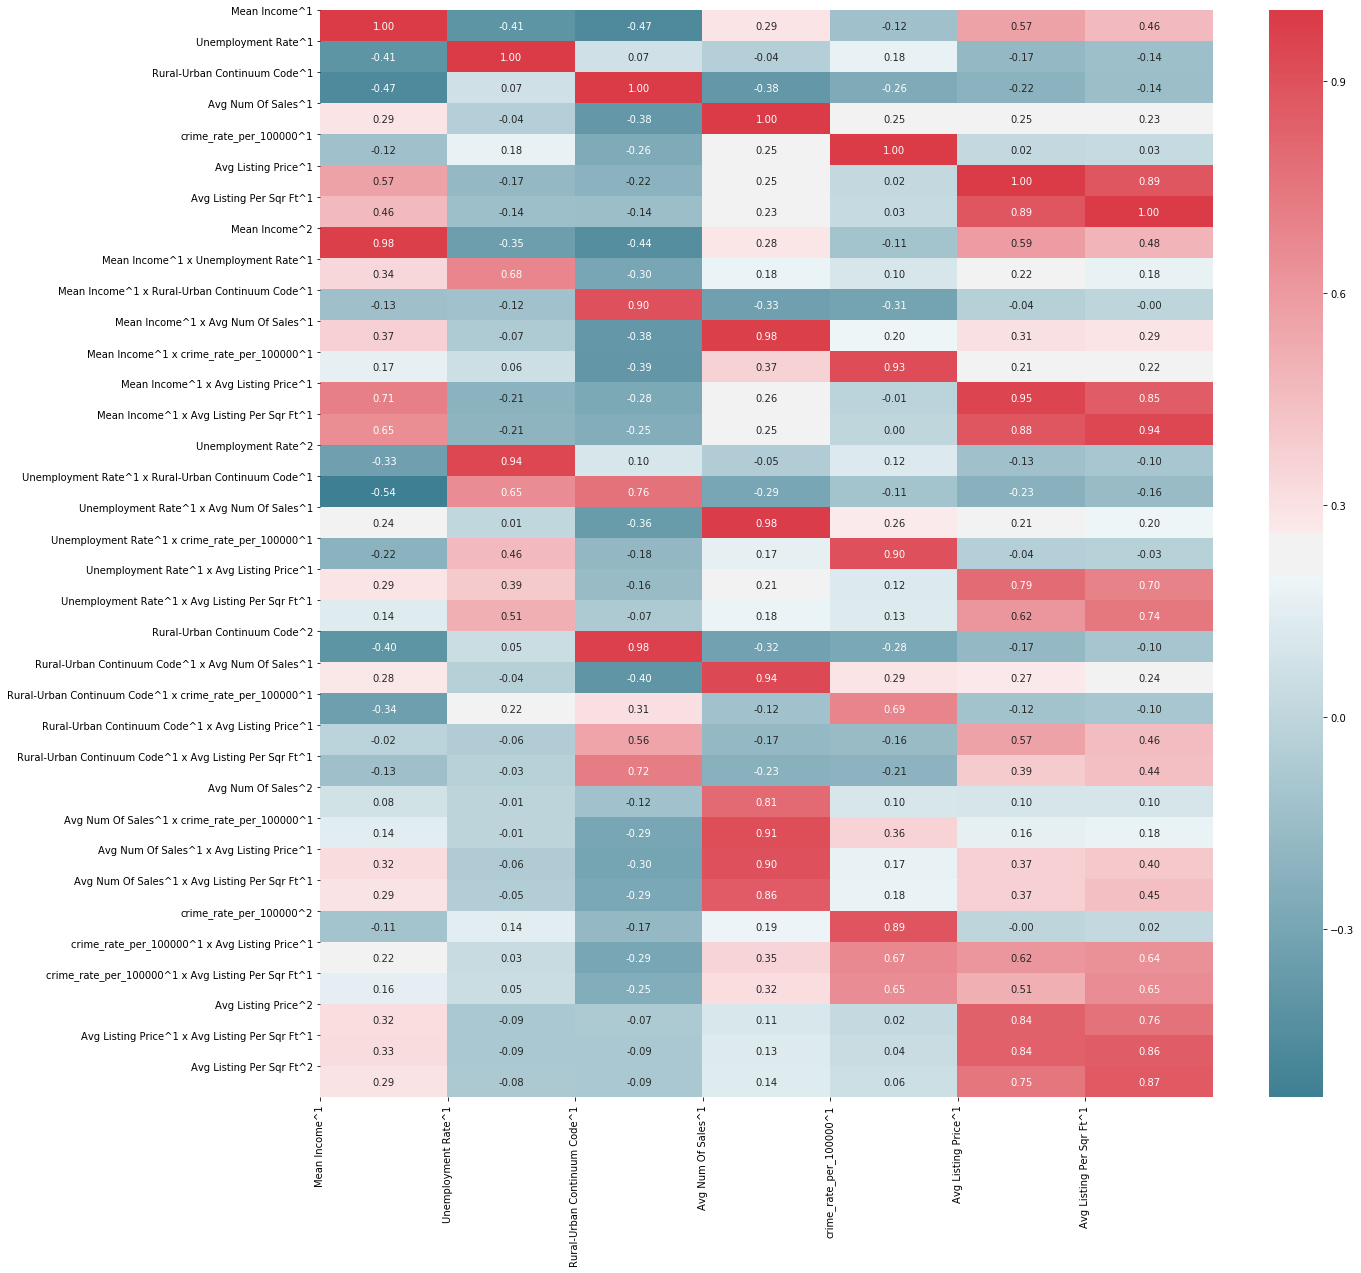

In [20]:
num_1st_order = to_examine_df.shape[1]
heatMap_nonSquare(expanded_feature_df,num_1st_order,(20,20))

From the above we can see that Mean Income is not strongly related with interaction terms which do not include Mean Income<br>
Neigther is Unemployment Rate, which I find very strange and interesting<br>
Neighther are the rest, which I find interesting. It appears that the only strong interaction between features in this space are Listing Pric and Lising Price per Sqr Ft.<br>
I had really expected at least a higher-order interaction correlation with Unemployment rate, which I did not find.

That said, there are interesting relationships which can be seen in the above plot.